In [1]:
clear

In [2]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

tf Graph Input

In [3]:
def nn(input):

    with tf.name_scope('layer1'):
        W0 = tf.Variable(tf.truncated_normal([11, 30], stddev=0.1))
        b0 = tf.Variable(tf.constant(value=0.1, shape=[30]))
        h0 = tf.matmul([input], W0) + b0

    with tf.name_scope('layer2'):
        W1 = tf.Variable(tf.truncated_normal([30, 30], stddev=0.1))
        b1 = tf.Variable(tf.constant(value=0.1, shape=[30]))
        h1 = tf.matmul(h0, W1) + b1

    with tf.name_scope('layer3'):
        W2 = tf.Variable(tf.truncated_normal([30, 3], stddev=0.1))
        b2 = tf.Variable(tf.constant(value=0.1, shape=[3]))
        h2 = tf.matmul(h1, W2) + b2

    return h2

In [4]:
expert_policy_file = "experts/Hopper-v1.pkl"
envname = "Hopper-v1"
render = False
num_rollouts = 5

In [5]:
policy_fn = load_policy.load_policy(expert_policy_file)

('obs', (1, 11), (1, 11))


SET UP tensorflow    

In [6]:
input = tf.placeholder(tf.float32, [11])
label = tf.placeholder(tf.float32, [3])

pred = nn(input)

cost = tf.losses.absolute_difference(label, pred[0])

train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)

import gym
env = gym.make(envname)
max_steps = env.spec.timestep_limit

returns = []
observations = []
actions = []

[2017-09-15 10:20:33,789] Making new env: Hopper-v1


In [7]:
 with tf.Session() as sess:
    tf_util.initialize()
    
    # Obtain data in simulation
    for i in range(num_rollouts):
        obs = env.reset()
        one = False
        totalr = 0.
        steps = 0
        done = False
        while not done:
            action = policy_fn(obs[None,:])
            observations.append(obs)

            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if render:
                env.render()
            if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)

    expert_data = {'observations': np.array(observations),
                   'actions': np.array(actions)}

    observations = np.array(observations)
    actions = np.array(actions)
    predicted_actions = []
    for k in range(1):
        # Learn new policy
        for i in range(observations.shape[0]):
            _, cost_, pred_action = sess.run([train_step, cost, pred], feed_dict={input: observations[i], label: actions[i][0]})
            predicted_actions.append(pred_action)
#        # Simulate using learned policy
#        obs = env.reset()
#        done = False
#        while not done:
#            pred_action = sess.run(pred, feed_dict={input: obs})

#            obs, r, done, _ = env.step(pred_action)
#            if render:
#                env.render()

Instructions for updating:
Please use tf.global_variables instead.


[2017-09-15 10:20:34,635] From tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-09-15 10:20:34,649] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/util/tf_should_use.py:175: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000


In [8]:
predicted_actions_array = np.array(predicted_actions)

In [12]:
evaluated_cost = np.sum(np.abs(actions-predicted_actions_array),axis=2)

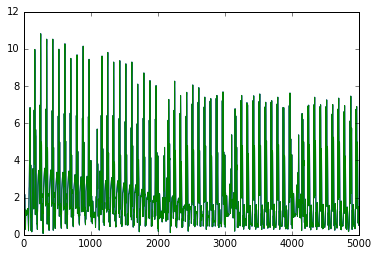

In [14]:
import matplotlib.pyplot as plt
plt.plot(evaluated_cost)
plt.show()